## Rock, Paper & Scissors with TensorFlow Hub - TFLite

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/mohan-mj/tflite-rock_paper_scissors/blob/main/tflite_rock_paper_scissors.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
</table>

### Import libraries

In [1]:
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

### Select the Hub/TF2 module to use

In [3]:
handle_base

'mobilenet_v2'

In [4]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE = f"https://tfhub.dev/google/tf2-preview/{handle_base}/feature_vector/4"
IMAGE_SIZE = (pixels, pixels)

## Data preprocessing

Use [TensorFlow Datasets](http://tensorflow.org/datasets) to load the rock, paper and scissors dataset.

If you have your own data, and are interested in importing using it with TensorFlow see [loading image data](Train_using_new_images.ipynb)

In [6]:
import tensorflow_datasets as tfds
# tfds.disable_progress_bar()

The `tfds.load` method downloads and caches the data, and returns a `tf.data.Dataset` object. These objects provide powerful, efficient methods for manipulating data and piping it into your model.

Since `"rock_paper_scissors"` doesn't define standard splits, use the subsplit feature to divide it into (train, validation, test) with 80%, 10%, 10% of the data respectively.

In [7]:
# splits = tfds.Split.all.subsplit(weighted=(80, 10, 10))
splits=['train[:80%]', 'train[80%:90%]', 'train[90%:]']

splits, info = tfds.load('rock_paper_scissors', with_info=True, as_supervised=True, split = splits)

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Dl Completed...: 100%|██████████| 2/2 [00:45<00:00, 22.78s/ url]


Dataset rock_paper_scissors downloaded and prepared to C:\Users\Z004408T\tensorflow_datasets\rock_paper_scissors\3.0.0. Subsequent calls will reuse this data.


### Format the Data

Use the `tf.image` module to format the images for the task.

Resize the images to a fixes input size, and rescale the input channels

In [8]:
def format_image(image, label):
  image = tf.image.resize(image, IMAGE_SIZE) / 255.0
  return  image, label


Now shuffle and batch the data


In [9]:
BATCH_SIZE = 32 #@param {type:"integer"}

In [10]:
train_batches = train_examples.shuffle(num_examples // 4).batch(BATCH_SIZE).map(format_image).prefetch(1)
validation_batches = validation_examples.batch(BATCH_SIZE).map(format_image).prefetch(1)
test_batches = test_examples.batch(1).map(format_image)

Inspect a batch

In [11]:
for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape

TensorShape([32, 224, 224, 3])

## Defining the model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [12]:
do_fine_tuning = False #@param {type:"boolean"}

In [13]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    hub.KerasLayer(MODULE_HANDLE,
                   input_shape=IMAGE_SIZE + (3, ), 
                   output_shape=[FV_SIZE],
                   trainable=do_fine_tuning),
    tf.keras.layers.Dense(num_classes)
])
model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


## Training the model

In [14]:
if do_fine_tuning:
  model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.002, momentum=0.9), 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
else:
  model.compile(
    optimizer='adam', 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [15]:
EPOCHS = 5
hist = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/5
63/63 [==============================] - 84s 1s/step - loss: 0.3734 - accuracy: 0.8834 - val_loss: 0.1025 - val_accuracy: 0.9921
Epoch 2/5
63/63 [==============================] - 86s 1s/step - loss: 0.0672 - accuracy: 0.9980 - val_loss: 0.0488 - val_accuracy: 0.9960
Epoch 3/5
63/63 [==============================] - 70s 1s/step - loss: 0.0363 - accuracy: 1.0000 - val_loss: 0.0313 - val_accuracy: 1.0000
Epoch 4/5
63/63 [==============================] - 67s 1s/step - loss: 0.0242 - accuracy: 1.0000 - val_loss: 0.0223 - val_accuracy: 1.0000
Epoch 5/5
63/63 [==============================] - 66s 1s/step - loss: 0.0175 - accuracy: 1.0000 - val_loss: 0.0171 - val_accuracy: 1.0000


## Export the model

In [16]:
RPS_SAVED_MODEL = "rps_saved_model"

Export the SavedModel

In [17]:
tf.saved_model.save(model, RPS_SAVED_MODEL)

INFO:tensorflow:Assets written to: rps_saved_model\assets


INFO:tensorflow:Assets written to: rps_saved_model\assets


In [18]:
loaded = tf.saved_model.load(RPS_SAVED_MODEL)

In [19]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_input')})
{'dense': TensorSpec(shape=(None, 3), dtype=tf.float32, name='dense')}


## Convert with TFLiteConverter

In [20]:
converter = tf.lite.TFLiteConverter.from_saved_model(RPS_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT]


tflite_model = converter.convert()
with open("converted_model.tflite", "wb") as f:
  f.write(tflite_model)

Test the TFLite model using the Python Interpreter

In [21]:
# Load TFLite model and allocate tensors.
tflite_model_file = 'converted_model.tflite'
with open(tflite_model_file, 'rb') as fid:
  tflite_model = fid.read()
  
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [22]:
from tqdm import tqdm

# Gather results for the randomly sampled test images
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(10)):
  interpreter.set_tensor(input_index, img)
  interpreter.invoke()
  predictions.append(interpreter.get_tensor(output_index))
  
  test_labels.append(label.numpy()[0])
  test_imgs.append(img)

100%|██████████| 10/10 [00:41<00:00,  4.16s/it]


In [23]:
#@title Utility functions for plotting
# Utilities for plotting

class_names = ['rock', 'paper', 'scissors']

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
    
  img = np.squeeze(img)

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  print(type(predicted_label), type(true_label))
  if predicted_label == true_label:
    color = 'green'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)


<class 'numpy.int64'> <class 'numpy.int64'>


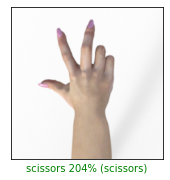

In [24]:
#@title Visualize the outputs { run: "auto" }
index = 8 #@param {type:"slider", min:0, max:9, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

Download the model

**NOTE: You might have to run to the cell below twice**

In [25]:
with open('labels.txt', 'w') as f:
  f.write('\n'.join(class_names))

# Prepare the test images for download (Optional)

This part involves downloading additional test images for the Mobile Apps only in case you need to try out more samples

In [26]:
!mkdir -p test_images

In [27]:
from PIL import Image

for index, (image, label) in enumerate(test_batches.take(50)):
  image = tf.cast(image * 255.0, tf.uint8)
  image = tf.squeeze(image).numpy()
  pil_image = Image.fromarray(image)
  pil_image.save('test_images/{}_{}.jpg'.format(class_names[label[0]], index))